In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra
using CairoMakie

using ModelingToolkit, OrdinaryDiffEq, FenrirForNeuro, ProbNumDiffEq

Axis = CairoMakie.Axis

In [ ]:
# helpers
function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        df[!, :iter] = 1:size(df, 1)
        push!(dfs, df)
    end
    return dfs
end

function simulate(prob, p, proj, saveat=nothing)
    tₛ, tₑ = prob.tspan
    sol = solve(
        remake(prob, p=p),
        RadauIIA5(),
        abstol=1e-14,
        reltol=1e-14,
        dense=false,
        saveat=saveat,
    )
    t_obs = sol.t[1:end]
    u_obs = vcat([(proj * u) for u in sol.u]...)
    return t_obs, u_obs
end

keys(θ) = map(θᵢ -> Symbol(θᵢ[1]), θ)
values(θ) = map(θᵢ -> θᵢ[2], θ)

In [ ]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 0.4 * HALF_WIDTH # inches

PT_PER_INCH = 72
HALF_WIDTH *= PT_PER_INCH
FULL_WIDTH *= PT_PER_INCH
HEIGHT *= PT_PER_INCH

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

PLOT_DEFAULTS = (titlesize = 7, xlabelsize = 7, ylabelsize = 7, xticklabelsize = 7, yticklabelsize = 7, xticksize = 2, yticksize = 2)

In [ ]:
@parameters gNa gK
θ = [gNa => 25, gK => 7]
prob_prior, prob = get_SinglecompartmentHH(θ)

σ² = 1e-1
dt_data = 1e-2
dt_sol = 1e-2
proj = [1 0 0 0]
data = generate_data(prob, proj, σ², dt_data)
t_obs, x_obs = data.t, vcat(data.u...)

T(t::Real)::Float64 = 10.0^(20.0 - t)
tempering_schedule = T.(LinRange(0, 20, 21))
other_params = (data=data, prob=prob, σ²=σ², proj=proj, order=3, dt=dt_sol, prior=prob_prior)
loss = get_fenrir_loss()

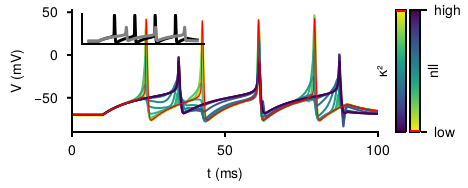

In [125]:
f = Figure(size=(HALF_WIDTH, HEIGHT), figure_padding=(5,15,5,5))

p_est = [5, 10]
ax = Axis(f[1, 1], xlabel="t (ms)", ylabel="V (mV)"; PLOT_DEFAULTS...)

t_obs, x_obs = simulate(prob, values(θ), proj, t_obs)
t_ode, x_ode = simulate(prob, p_est, proj, t_obs)

κ²_subset = tempering_schedule[5:end-5]
ls = [loss(p_est, (other_params..., logκ²=log.(κ²)))[1] for κ² in κ²_subset]
nll_bounds = [extrema(ls)...]
κ²_bounds = [extrema(log10.(κ²_subset))...]
for κ² in reverse(κ²_subset)
    l, t_pn, x_pn = loss(p_est, (other_params..., logκ²=log.(κ²)))
    μ = ProbNumDiffEq.stack([x_i.μ for x_i in x_pn])[:, 1]
    lines!(ax, t_pn, μ, color=log10.(κ²), colormap=:viridis, colorrange=κ²_bounds, linewidth=1)
end

# optimal κ²
κ²_opt = κ²_subset[argmin(ls)]
l, t_pn_opt, x_pn_opt = loss(p_est, (other_params..., logκ²=log.(κ²_opt)))
μ_opt = ProbNumDiffEq.stack([x_i.μ for x_i in x_pn_opt])[:, 1]
lines!(ax, t_pn_opt, μ_opt, color=:red, linewidth=0.5)

# include nll
cbar = Colorbar(f[1, 2], label="κ²", ticklabelsize=0, limits=κ²_bounds, ticks=(κ²_bounds, ["", ""]), labelsize=7, size=5, ticksize=0, labelpadding=-20)
cbar = Colorbar(f[1, 3], label="nll", ticklabelsize=7, limits=nll_bounds, ticks=(nll_bounds, ["low", "high"]), labelsize=7, size=5, ticksize=3, labelpadding=-18, colormap=cgrad(:viridis, rev=true))
colgap!(f.layout, 2, Relative(0.01))

cbar_ax1 = Axis(f[1, 2])
hlines!(cbar_ax1, [log10.(κ²_opt)], color=:red, linewidth=2)
ylims!(cbar_ax1, κ²_bounds)
hidespines!(cbar_ax1)
hidedecorations!(cbar_ax1)

cbar_ax2 = Axis(f[1, 3])
hlines!(cbar_ax2, [minimum(ls)], color=:red, linewidth=2)
ylims!(cbar_ax2, nll_bounds)
hidespines!(cbar_ax2)
hidedecorations!(cbar_ax2)

colgap!(f.layout, 1, Relative(0.05))
xlims!(ax, (0, 100))
hidespines!(ax, :t, :r)
hidedecorations!(ax, grid=true, label=false, ticks=false, ticklabels=false)

ax_inset = Axis(f[1, 1], width=Relative(0.4), height=Relative(0.24), halign=0.05, valign=0.95, backgroundcolor=:white)
lines!(ax_inset, t_obs, x_obs, color=:black)
lines!(ax_inset, t_ode, x_ode, color=:grey)
hidespines!(ax_inset, :t, :r)
hidedecorations!(ax_inset)
xlims!(ax, (0, 100))

f

In [126]:
save(joinpath(FIGURES_PATH, "figure2.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}
